# Transformer in PyTorch

This is a pytorch implementation of the Transformer, which is also my note.

<img src="https://i.imgur.com/thaMgTE.png"/>

## Import Dependencies

In [1]:
!pip3 install --upgrade torch torchvision torchtext
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import spacy

import random
import math
import os
import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_num = '0'
device = torch.device('cuda:'+device_num if torch.cuda.is_available() else 'cpu')
print('device type:', device)

device type: cuda:0


## Prepare for Dataset

In [4]:
import torchtext
from torchtext.datasets import TranslationDataset, Multi30k, IWSLT
from torchtext import data

!python -m spacy download de
!python -m spacy download en
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Define toeknizers for both languages.

In [0]:
# Tokenizes German
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

# Tokenizes English
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

Preprocess them as source and target. ```<sos>``` stands for Start Of Sentence and ```<eos>``` for End Of Sentence. Set ```batch_first``` to true so batch_size would be the first dimension.

In [0]:
# source (Gernam)
GER = data.Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

# target (English)
ENG = data.Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

Split into train and test set, and build the vocab.

In [0]:
MAX_LEN = 100
MIN_FREQ = 2

train_data, valid_data, test_data = Multi30k.splits(
    exts=('.de', '.en'), 
    fields=(GER, ENG), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN
)

GER.build_vocab(train_data, min_freq=MIN_FREQ)
ENG.build_vocab(train_data, min_freq=MIN_FREQ)

Batchify the data.

In [0]:
BATCH_SIZE = 128

train_iterator = data.BucketIterator(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    sort_key=lambda x: data.interleave_keys(len(x.src), len(x.trg)), 
    device=device
)

valid_iterator = data.BucketIterator(
    dataset=valid_data, 
    batch_size=BATCH_SIZE, 
    device=device
)

test_iterator = data.BucketIterator(
    dataset=test_data, 
    batch_size=BATCH_SIZE, 
    device=device
)

## Transformer Model

### Multi-Head Attention (SubLayer)

The following image illustrates a single attention head and Multi-Head attention.

<img src="https://i.imgur.com/ScaPfNh.png"/>

and the Scaled Dot-Product attention is represented by the formula:

<img src="https://i.imgur.com/vrnyrgS.png" width="550"/>

In [0]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, scaled_term, attn_dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.scaled_term = scaled_term
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        # Score
        attn = torch.matmul(q, k) # [B, n_head, T, T]
        attn = attn / self.scaled_term

        if mask is not None:
            attn = attn.masked_fill(mask==0, -1e10)

        attn = self.softmax(attn) # [B, n_head, T, T]
        attn = self.dropout(attn)
        
        # Sum
        output = torch.matmul(attn, v) # [B, n_head, T, H//n_head]

        return output, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, n_head, device, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.n_head = n_head

        self.w_q = nn.Linear(hidden_size, hidden_size)
        self.w_k = nn.Linear(hidden_size, hidden_size)
        self.w_v = nn.Linear(hidden_size, hidden_size)
        self.scaled_dot_attention = ScaledDotProductAttention(torch.sqrt(torch.FloatTensor([hidden_size//n_head])).to(device))
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size, hidden_size)
        self.device = device

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]
        '''
        query = key = value: [B, T, H]
        mask: [B, T, 1]
        '''
        # Project and split
        q = self.w_q(q).view(batch_size, -1, self.n_head, self.hidden_size//self.n_head) # [B, T, H] -> [B, T, n_head, H//n_head]
        k = self.w_k(k).view(batch_size, -1, self.n_head, self.hidden_size//self.n_head) # [B, T, H] -> [B, T, n_head, H//n_head]
        v = self.w_v(v).view(batch_size, -1, self.n_head, self.hidden_size//self.n_head) # [B, T, H] -> [B, T, n_head, H//n_head]
        
        q = q.permute(0, 2, 1, 3) # [B, n_head, T, H//n_head]
        k = k.permute(0, 2, 3, 1) # [B, n_head, H//n_head, T]
        v = v.permute(0, 2, 1, 3) # [B, n_head, T, H//n_head]

        output, attn = self.scaled_dot_attention(q, k, v, mask) # [B, n_head, T, T], [B, n_head, T, H//n_head]
        output = output.transpose(1, 2).contiguous() # [B, T, n_head, H//n_head]
        output = output.view(batch_size, -1, self.n_head * (self.hidden_size//self.n_head)) # [B, T, H]
        
        output = self.output_layer(output)
        output = self.dropout(output)
        
        # return output, attn
        return output

### Encoder Layer

<img src="https://i.imgur.com/dZwWje2.png" />

#### Post-LN or Pre-LN

You can find different version of Transformer implementation that use either Post-LayerNormalization or Pre-LayerNormalization on github. Here we use the flag ```pre_lnorm``` to decide whether it is Pre-LN or not.

According to the official implementation note, whether there's a Pre-LN or not, we must apply LayerNorm to the last output of both Encoder and Decoder, since the output can grow very large, being the sum of a whole stack of unnormalized lauer outputs.

<img src="https://i.imgur.com/s7TkryI.png"/>

And here's the table for detail:

<img src="https://i.imgur.com/J1bx9yC.png" />

As my experiment results, Pre-LN converge much faster than Post-LN, and Pre-LN doesn't even need warm-up steps.

In [0]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout):
        super(PositionwiseFeedForward, self).__init__()
        self.pff = nn.Sequential(
            nn.Linear(hidden_size, filter_size), 
            nn.ReLU(inplace=True), 
            nn.Dropout(dropout), 
            nn.Linear(filter_size, hidden_size), 
            nn.Dropout(dropout)
        )
    
    def forward(self, src):
        src = self.pff(src)

        return src
        
    
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, n_head, pre_lnorm, device, dropout):
        super(EncoderLayer, self).__init__()
        # self-attention part
        self.self_attn = MultiHeadAttention(hidden_size, n_head, device)
        self.self_attn_norm = nn.LayerNorm(hidden_size)
        
        # feed forward network part
        self.pff = PositionwiseFeedForward(hidden_size, filter_size, dropout)
        self.pff_norm = nn.LayerNorm(hidden_size)

        self.pre_lnorm = pre_lnorm
        
    def forward(self, src, src_mask):
        if self.pre_lnorm:
            pre = self.self_attn_norm(src)
            src = src + self.self_attn(pre, pre, pre, src_mask) # residual connection

            pre = self.pff_norm(src)
            src = src + self.pff(pre) # residual connection
        else:
            src = self.self_attn_norm(src + self.self_attn(src, src, src, src_mask)) # residual connection + layerNorm
            src = self.pff_norm(src + self.pff(src)) # residual connection + layerNorm
        
        return src

### Encoder

Encoder consists of multiple layers of EncoderLayer. And also remember the last LayerNorm metioned previously.

#### Embeddings: Token Embeddings (wte) + Positional Encoding (wpe)

<img src="https://i.imgur.com/PWBhjhL.png" />

We may see lots of ways to implement positional encoding. Here are some of the common ways:

1. nn.Embedding(...).
    - The weight could be previously defined, or simply a fresh new embeddings.
    - It could be trainable or un-trainable. The idea of the paper is to use a fixed table.

2. A class instance.
    - Like [huggingface's transformer](https://github.com/huggingface/transformers/blob/master/transformers/modeling_transfo_xl.py).

As what I've tested, they could achieve similar result, with nn.Embedding() slighly better. Using fresh new trainable nn.Embedding() or loading the pretrained weight doesn't make much differnce. I leave all the implementations here as a note.

In [0]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_size):
        super(PositionalEmbedding, self).__init__()
        self.embed_size = embed_size # hidden_size

        inv_timescales = 1 / (10000 ** (torch.arange(0.0, embed_size, 2.0) / embed_size))
        self.register_buffer('inv_timescales', inv_timescales)

    def forward(self, pos):
        scaled_time = torch.ger(pos, self.inv_timescales) # [T, H//2]
        pos_embed = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=-1) # [T, H]
        
        return pos_embed[None, :, :]

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return x

In [0]:
def positional_encoding_table(n_position, d_hid, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embed_scale = hidden_size ** 0.5
        self.wte = nn.Embedding(input_size, hidden_size) # token embeddings
        # self.wpe = PositionalEmbedding(hidden_size) # positional embeddings
        # self.wpe = nn.Embedding(1000, hidden_size)
        # self.wpe = PositionalEncoding(hidden_size)
        max_len = 1000
        self.wpe = nn.Embedding.from_pretrained(positional_encoding_table(max_len+1, hidden_size, padding_idx=GER.vocab.stoi['<pad>']), freeze=True)
        self.embed_dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderLayer(hidden_size, filter_size, n_head, pre_lnorm, device, dropout) 
                                     for _ in range(n_layers)])
        self.pre_lnorm = pre_lnorm
        self.last_norm = nn.LayerNorm(hidden_size)
        self.device = device
        
    def forward(self, src, src_mask):
        # token embedding + positional encoding
        # pos = torch.arange(src.shape[1], dtype=torch.float32).to(self.device)
        pos = torch.arange(0, src.shape[1]).unsqueeze(0).repeat(src.shape[0], 1).to(self.device)
        src = self.wte(src) * self.embed_scale + self.wpe(pos) # [B, T, H]
        src = self.embed_dropout(src)
        
        for layer in self.layers:
            src = layer(src, src_mask)
        
        if self.pre_lnorm:
            src = self.last_norm(src)
        
        return src

### Decoder Layer

<img src="https://i.imgur.com/y4ZE8UL.png" />

Target masking is a crutial part in decoder. It masked out the rest of the sequence after current time step, so the model won't peek the answer. Otherwise, we may find low training perplexity but suck at testing.

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, n_head, pre_lnorm, device, dropout):
        super(DecoderLayer, self).__init__()
        # self-attention part
        self.self_attn = MultiHeadAttention(hidden_size, n_head, device)
        self.self_attn_norm = nn.LayerNorm(hidden_size)
        
        # encoder-to-decoder self-attention part
        self.ed_self_attn = MultiHeadAttention(hidden_size, n_head, device)
        self.ed_self_attn_norm = nn.LayerNorm(hidden_size)
        
        # feed forward network part
        self.pff = PositionwiseFeedForward(hidden_size, filter_size, dropout)
        self.pff_norm = nn.LayerNorm(hidden_size)

        self.pre_lnorm = pre_lnorm
        
    def forward(self, enc_out, enc_out_mask, trg, trg_mask):
        if self.pre_lnorm:
            ris = self.self_attn_norm(trg)
            trg = trg + self.self_attn(ris, ris, ris, trg_mask)

            ris = self.ed_self_attn_norm(trg)
            trg = trg + self.ed_self_attn(ris, enc_out, enc_out, enc_out_mask)

            ris = self.pff_norm(trg)
            trg = trg + self.pff(ris)
        else:
            trg = self.self_attn_norm(trg + self.self_attn(trg, trg, trg, trg_mask))
            trg = self.ed_self_attn_norm(trg + self.ed_self_attn(trg, enc_out, enc_out, enc_out_mask))
            trg = self.pff_norm(trg + self.pff(trg))
            
        return trg

### Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.embed_scale = hidden_size ** 0.5
        self.wte = nn.Embedding(input_size, hidden_size) # token embeddings
        # self.wpe = PositionalEmbedding(hidden_size) # positional embeddings
        # self.wpe = nn.Embedding(1000, hidden_size)
        # self.wpe = PositionalEncoding(hidden_size)
        max_len = 1000
        self.wpe = nn.Embedding.from_pretrained(positional_encoding_table(max_len+1, hidden_size, padding_idx=ENG.vocab.stoi['<pad>']), freeze=True)
        self.embed_dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderLayer(hidden_size, filter_size, n_head, pre_lnorm, device, dropout)
                                     for _ in range(n_layers)])
        self.pre_lnorm = pre_lnorm
        self.last_norm = nn.LayerNorm(hidden_size)
        self.device = device
        
    def forward(self, enc_out, enc_out_mask, trg, trg_mask):
        # token embedding + positional encoding
        # pos = torch.arange(trg.shape[1], dtype=torch.float32).to(self.device)
        pos = torch.arange(0, trg.shape[1]).unsqueeze(0).repeat(trg.shape[0], 1).to(self.device)
        trg = self.wte(trg) * self.embed_scale + self.wpe(pos) # [B, T, H]
        trg = self.embed_dropout(trg)
        
        for layer in self.layers:
            trg = layer(enc_out, enc_out_mask, trg, trg_mask)
        
        if self.pre_lnorm:
            trg = self.last_norm(trg)
        
        return trg

### Transformer

Now put all the layers together.

In [0]:
class Transformer(nn.Module):
    def __init__(self, enc_input_size, dec_input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device, maxlen=50):
        super(Transformer, self).__init__()
        self.encoder = Encoder(enc_input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device)
        self.decoder = Decoder(dec_input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device)
        self.project = nn.Linear(hidden_size, dec_input_size)
        self.maxlen = maxlen
        self.src_sos_idx = GER.vocab.stoi['<sos>']
        self.src_eos_idx = GER.vocab.stoi['<eos>']
        
    def forward(self, src, src_mask, trg, trg_mask):
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(enc_out, src_mask, trg, trg_mask)
        output = self.project(dec_out)
        
        return output
        
    def inference(self, src):
        batch_size, src_len = src.shape
        trg = src.new_full((batch_size, 1), self.src_sos_idx)
        src_mask, trg_mask = make_masks(src, trg)
        
        enc_out = self.encoder(src, src_mask)
        
        for t in range(self.maxlen-1):
            dec_out = self.decoder(enc_out, src_mask, trg, trg_mask) # [B, T, H]
            output = self.project(dec_out) # [B, vocab_size]
            output = torch.argmax(output[:, -1], dim=1) # [B]
            output = output.unsqueeze(1) # [B, 1]
            trg = torch.cat((trg, output), dim=1)
            src_mask, trg_mask = make_masks(src, trg)
            
        return trg
        

## Train the model

### Masking

In [0]:
# helper function to make mask for source and target.
def make_masks(src, trg):
    src_mask = (src != GER.vocab.stoi['<pad>']).unsqueeze(1).unsqueeze(2)
    trg_pad_mask = (trg != GER.vocab.stoi['<pad>']).unsqueeze(1).unsqueeze(3)

    trg_len = trg.shape[1]

    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=device)).bool()

    trg_mask = trg_pad_mask & trg_sub_mask

    return src_mask, trg_mask

In [0]:
enc_input_size = len(GER.vocab) # enc_vocab_size
dec_input_size = len(ENG.vocab) # dec_vocab_size
hidden_size = 512
n_layers = 6
n_head = 8
filter_size = 2048
dropout = 0.1
pre_lnorm = False
# lr = 1.5e-3
lr = 7e-4
betas = (0.9, 0.98)
eps = 1e-09
factor = 0.5
warmup = 2000
n_epoch = 10
clip_value = 1

In [0]:
model = Transformer(enc_input_size, dec_input_size, hidden_size, filter_size, n_head, dropout, n_layers, pre_lnorm, device)
model = model.to(device)

Initialize model parameters

In [0]:
for param in model.parameters():
    if param.dim() > 1:
        nn.init.xavier_uniform_(param)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=GER.vocab.stoi['<pad>'])
criterion = criterion.to(device)

### Warm up optimizer

In [0]:
class NoamOpt:
    def __init__(self, optimizer, hidden_size, factor, warmup, step=0):
        self.constant = hidden_size ** -0.5
        self.factor = factor
        self.curr_step = step
        self._rate = 0
        self.warmup = warmup
        self.optimizer = optimizer

    def step(self):
        self.curr_step += 1
        lr = self.learning_rate()
        self._rate = lr
        for param in self.optimizer.param_groups:
            param['lr'] = lr
        
        self.optimizer.step()

    def learning_rate(self, step=None):
        if step is None:
            step = self.curr_step
        lr = self.factor * (self.constant * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        return lr

    def zero_grad(self):
        self.optimizer.zero_grad()

This is how our learning rate changes over iterations. It reaches the peak point at warm-up steps, and then decays in inverse square root term.

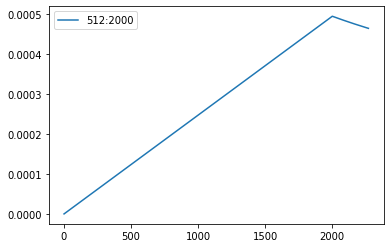

In [24]:
opts = [NoamOpt(None, 512, factor, warmup)]
total_step = n_epoch * len(train_iterator)
plt.plot(np.arange(1, total_step), [[opt.learning_rate(i) for opt in opts] for i in range(1, total_step)])
plt.legend([f"{hidden_size}:{warmup}"])
None

In [0]:
if pre_lnorm:
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps) # no warm up
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, min_lr=1e-9, verbose=True)
else:
    # optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps) # no warm up
    optimizer = NoamOpt(optim.Adam(model.parameters(), lr=0, betas=betas, eps=eps), hidden_size, factor, warmup)

### Training loop and validate loop

The actual target sequence is trg[:-1] = $[sos, x1, x1, ...]$, 

and the model output should be the prediction given the actual target token = $[y1, y2, ..., eos]$.

When calculating loss, cut off the <sos> token from trg to match the output of model, which is trg[1:] = $[x1, x2, ..., eos]$

In [0]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in tqdm(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        src_mask, trg_mask = make_masks(src, trg[:, :-1])
        output = model(src, src_mask, trg[:, :-1], trg_mask) # [B, T-1, output_size]
        
        output = output.contiguous().view(-1, output.shape[-1]) # [B*(T-1), output_size]
        trg = trg[:, 1:].contiguous().view(-1) # [B*(T-1)]

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        
        epoch_loss += float(loss.item())

        if np.isnan(epoch_loss):
            assert False, "gradient explode"
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch in tqdm(iterator):

            src = batch.src
            trg = batch.trg

            src_mask, trg_mask = make_masks(src, trg[:, :-1])
            output = model(src, src_mask, trg[:, :-1], trg_mask) # [B, T-1, output_size]
            
            output = output.contiguous().view(-1, output.shape[-1]) # [B*(T-1), output_size]
            trg = trg[:,1:].contiguous().view(-1) # [B*(T-1)]
            
            loss = criterion(output, trg)
            
            epoch_loss += float(loss.item())
        
    return epoch_loss / len(iterator)

In [0]:
def translate_sentence(model, sentence, src_field, trg_field):
    model.eval()

    if isinstance(sentence, str):
        tokenizer = spacy.load('de')
        tokens = [token.text.lower() for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    trg_indexes = model.inference(src_tensor)
    trg_indexes = trg_indexes[0]
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    trg_tokens = trg_tokens[1:] # get rid of <sos>
    if "<eos>" in trg_tokens:
        trg_tokens = trg_tokens[:trg_tokens.index("<eos>")] # get rid of <eos>

    return trg_tokens

## BLEU

One of the most important benchmark for Machine Translation evaluation. I use ```corpus_bleu``` from nltk package to calculate the bleu score here. For more details, you can refer to [this article](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(model, data):

    bleu = 0.0
    reference = []
    candidate = []
    
    for datum in tqdm(data):

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        # src_mask, trg_mask = make_masks(src, trg[:, :-1])

        pred = translate_sentence(model, src, GER, ENG)

        reference.append([trg])
        candidate.append(pred)

    bleu = corpus_bleu(reference, candidate)
    bleu *= 100

    return bleu

In [0]:
def calculate_time(start_time, end_time):
    second = end_time - start_time
    hour = math.floor(second / 3600)
    minute = second - hour * 3600
    minute = math.floor(minute / 60)
    second -= (minute * 60 + hour * 3600)
    
    return hour, minute, second

In [31]:
best_valid_loss = float('inf')
epoch_record = []
bleu_score_record = []
train_loss_record = []
valid_loss_record = []

start_time = time.time()

for epoch in range(n_epoch):
    # if pre_lnorm:
    #     if epoch+1 == 6:
    #         for param in optimizer.param_groups:
    #             param['lr'] *= 0.1
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    bleu_value = calculate_bleu(model, test_data)
    # bleu_value = 0
    
    if pre_lnorm:
        lr_scheduler.step(valid_loss)

    end_time = time.time()
    
    hour, minute, second = calculate_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    epoch_record.append(epoch+1)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    bleu_score_record.append(bleu_value)

    print('-----------------------------------------------------------------------------------------------')
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f} | Bleu Score: {bleu_value:.2f} | Since: {hour}h {minute}m {second:.0f}s')
    print(f'lr: {optimizer._rate:2f} | #step: {optimizer.curr_step}')
    print('-----------------------------------------------------------------------------------------------')
    time.sleep(0.5)

100%|██████████| 1000/1000 [07:40<00:00,  2.16it/s]


-----------------------------------------------------------------------------------------------
Epoch: 01 | Train Loss: 6.469 | Validation Loss: 4.631 | Bleu Score: 2.23 | Since: 0h 8m 43s
lr: 0.000056 | #step: 227
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:47<00:00,  2.16it/s]


-----------------------------------------------------------------------------------------------
Epoch: 02 | Train Loss: 4.203 | Validation Loss: 3.593 | Bleu Score: 9.18 | Since: 0h 17m 34s
lr: 0.000112 | #step: 454
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:42<00:00,  2.22it/s]


-----------------------------------------------------------------------------------------------
Epoch: 03 | Train Loss: 3.458 | Validation Loss: 3.088 | Bleu Score: 12.56 | Since: 0h 26m 20s
lr: 0.000168 | #step: 681
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:32<00:00,  2.23it/s]


-----------------------------------------------------------------------------------------------
Epoch: 04 | Train Loss: 3.010 | Validation Loss: 2.780 | Bleu Score: 15.23 | Since: 0h 34m 56s
lr: 0.000224 | #step: 908
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]


-----------------------------------------------------------------------------------------------
Epoch: 05 | Train Loss: 2.693 | Validation Loss: 2.591 | Bleu Score: 16.48 | Since: 0h 43m 32s
lr: 0.000280 | #step: 1135
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:32<00:00,  2.23it/s]


-----------------------------------------------------------------------------------------------
Epoch: 06 | Train Loss: 2.450 | Validation Loss: 2.442 | Bleu Score: 17.64 | Since: 0h 52m 8s
lr: 0.000336 | #step: 1362
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]


-----------------------------------------------------------------------------------------------
Epoch: 07 | Train Loss: 2.242 | Validation Loss: 2.343 | Bleu Score: 19.34 | Since: 1h 0m 43s
lr: 0.000393 | #step: 1589
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:31<00:00,  2.24it/s]


-----------------------------------------------------------------------------------------------
Epoch: 08 | Train Loss: 2.069 | Validation Loss: 2.259 | Bleu Score: 19.11 | Since: 1h 9m 18s
lr: 0.000449 | #step: 1816
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]


-----------------------------------------------------------------------------------------------
Epoch: 09 | Train Loss: 1.925 | Validation Loss: 2.224 | Bleu Score: 20.30 | Since: 1h 17m 53s
lr: 0.000489 | #step: 2043
-----------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [07:33<00:00,  2.19it/s]


-----------------------------------------------------------------------------------------------
Epoch: 10 | Train Loss: 1.767 | Validation Loss: 2.152 | Bleu Score: 20.63 | Since: 1h 26m 28s
lr: 0.000464 | #step: 2270
-----------------------------------------------------------------------------------------------


In [0]:
file_path = '/content/drive/My Drive/transformer_checkpoint/'
if pre_lnorm:
    torch.save(epoch_record, file_path+'epoch_record_pre.pkl')
    torch.save(bleu_score_record, file_path+'bleu_score_record_pre.pkl')
    torch.save(train_loss_record, file_path+'train_loss_record_pre.pkl')
    torch.save(valid_loss_record, file_path+'valid_loss_record_pre.pkl')
else:
    torch.save(epoch_record, file_path+'epoch_record_post.pkl')
    torch.save(bleu_score_record, file_path+'bleu_score_record_post.pkl')
    torch.save(train_loss_record, file_path+'train_loss_record_post.pkl')
    torch.save(valid_loss_record, file_path+'valid_loss_record_post.pkl')

In [0]:
file_path = '/content/drive/My Drive/transformer_checkpoint/'

epoch_record_pre = torch.load(file_path+'epoch_record_pre.pkl')
bleu_score_record_pre = torch.load(file_path+'bleu_score_record_pre.pkl')
train_loss_record_pre = torch.load(file_path+'train_loss_record_pre.pkl')
valid_loss_record_pre = torch.load(file_path+'valid_loss_record_pre.pkl')

epoch_record_post = torch.load(file_path+'epoch_record_post.pkl')
bleu_score_record_post = torch.load(file_path+'bleu_score_record_post.pkl')
train_loss_record_post = torch.load(file_path+'train_loss_record_post.pkl')
valid_loss_record_post = torch.load(file_path+'valid_loss_record_post.pkl')

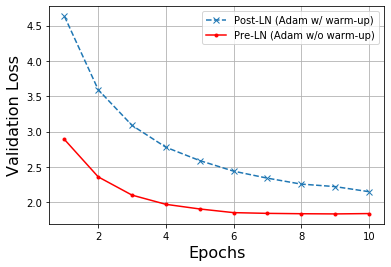

In [37]:
plt.plot(epoch_record, valid_loss_record_post, 'x--', label='Post-LN (Adam w/ warm-up)')
plt.plot(epoch_record, valid_loss_record_pre, '.-', color="red", label='Pre-LN (Adam w/o warm-up)')
# plt.title('')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)
plt.legend()
plt.grid()
plt.show()

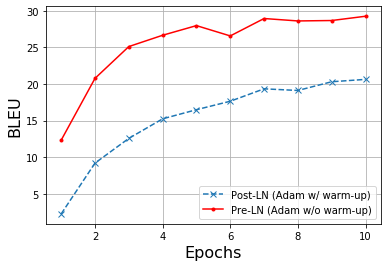

In [38]:
plt.plot(epoch_record, bleu_score_record_post, 'x--', label='Post-LN (Adam w/ warm-up)')
plt.plot(epoch_record, bleu_score_record_pre, '.-', color="red", label='Pre-LN (Adam w/o warm-up)')
# plt.title('')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('BLEU', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [39]:
source_sentence = ["<sos>"] + train_data[5].src + ["<eos>"]
target_sentence = ["<sos>"] + train_data[5].trg + ["<eos>"]
pred_token = translate_sentence(model, source_sentence, GER, ENG)
print('source:', ' '.join(source_sentence))
print('target:', ' '.join(target_sentence))
print('inference:', ' '.join(pred_token))

source: <sos> ein mann in grün hält eine gitarre , während der andere mann sein hemd ansieht . <eos>
target: <sos> a man in green holds a guitar while the other man observes his shirt . <eos>
inference: a man in green is holding a green guitar while the other man is playing his guitar .
